In [1]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
	    .builder \
	    .appName("Python Spark SQL basic example") \
	    .config("spark.some.config.option", "some-value") \
	    .getOrCreate()
                            

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/21 22:14:29 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/04/21 22:14:29 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/04/21 22:14:29 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/04/21 22:14:29 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [53]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, DateType
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [10]:
data = spark.read.csv(path='/shared/TransitTrends/MTA_CLEAN/daily_counts.csv', header=True, inferSchema=True)



In [20]:
#Show annual entries and exits
data.groupBy(F.year("DATE").alias("Year")).agg(F.sum("ENTRIES").alias("Entries"),F.sum("EXITS").alias("Exits")).show()

+----+----------+----------+
|Year|   Entries|     Exits|
+----+----------+----------+
|2022| 726041587|1007363574|
|2019|1796202332|1437212451|
|2020| 658950428| 606841133|
|2021| 653739773| 739071883|
+----+----------+----------+



In [44]:
#find daily exits and save as a regular pandas dataframe to plot the same

daily_exits= data.groupBy("DATE").agg(F.sum("EXITS").alias("Exits")).toPandas()

daily_exits['Date'] = pd.to_datetime(daily_exits['DATE'])

daily_exits = daily_exits.sort_values(by='Date')

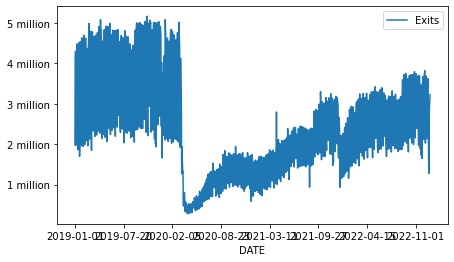

In [67]:
#plot daily exits and save the figure (Saved in the present working directory)
fig, ax = plt.subplots(figsize=(14, 8))
daily_exits.plot.line(x="DATE", y="Exits", ax=ax)

def millions_format(value, tick_number):
    return f'{int(value/1000000)} million'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_format))

plt.savefig('daily_exits_plot.png', dpi=300)

<Figure size 432x288 with 0 Axes>